# Fraud Detection
Nov. 2018

Lu Zhang

## Goal: 
The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of new user is fraudulent.

## <a id='summary' style='color:black'>Outline: </a>
1. Data Preprocessing
2. Exploratory Data Analysis & Feature Engineering
3. Model Training and Selection
4. Hyperparameter Tuning
5. Findings & Suggestion

### [1. Data Preprocessing](#data_processing)

For this analysis, I will use `pandas` for data manipulation, `matplotlib` for plotting, and `sklearn` for machine learning. 

**1.1 Data loading and browsing**

**1.2 Data preparation**: Join dataframes

**1.3 Data cleansing**

**1.4 Data transformation**: Transform time-series variable


### [2. Exploratory Data Analysis and Feature Engineering](#eda)
* I performed EDA with target, checked relationship between variables and response, and generated features as necessary.

**2.1 Transaction Attributes:**
* `age`, `country`: Categorical features with too many levels.I binned the features down to reduce model complexity

* `purchase_value`: Fraudster are tend to place many orders with identical `purchase_value` . Feature `order_cnt` was generated to monitor how many orders with same value a customer place.

**2.2 Transaction Digital Foot Prints:**
* `source`: Fraud transactions happend more from direct visiting.
* `browser`: Fraudsters use chrome more often than other browsers.

**2.3 Times:**
* In order to take advantage of time series variables, we could create `day_of_week`, `hour_of_day` features for signup and purchase respectively. 
* Fraudsters are more likely to place order immediately after signing up without browsing content of webpage. So we could generate feature `signup_purchase_delta` to cap this information.

**2.4 Transaction Frequencies:**
* Frausters may use same `device_id` or same `ip_address` for multiple transactions. More than half of users who signed up with same device more than once are fraudulent. So we could generate features `signup_anomaly` and `ip_anomaly` to monitor users' signup and purchase behavior.
* We could also generate `{count}_signup_last_{time_window}_by_{device,ip}` to measure user transactions' frequency. 

### [3. Model Building](#build)
First, we'll split variables into features (X) and target (y), and split data into a training(70%) and test(30%) set. 

**3.1 Metrics for Model Comparison**
* precision, recall, f1-score: Since our data is highly imbalanced, we should consider both precision and racall, rather than just accuracy.

* ROC plot and AUC

* Profit curve

**3.2 Model building preparation**

**3.3 Logistic regression (with regularization)**

**3.4 Random forest**

**3.5 Gradient boosting tree**

* Model comparision:

Model|Accuracy|Precision|Recall|F1-score|AUC
-----|--------|---------|------|--------|----
Logistic Regression|0.9570|0.9988|0.5252|0.6884|0.8260
Random Forest|0.9570|0.9988|0.5252|0.6884|0.8283
Gradient Boosting Tree|0.9569|0.9942|0.5264|0.6887|0.8293

* **Without any model tuning, gradient boosting seems to have the best performance** based on the metrics: highest recall, ROC plot with highest AUC. 

**3.6 Down-sampling:**

* All the 3 models' performance have very high precision and poor recall. This is because the data set is imbalanced. 
* Models built on imbalanced data tend to show a bias to the majority class, treating the minority class as noise. 
* Moreover, model evaluation metrics have problems, too. When accuracy seems very high, it may just ignore the minority class. So the classifiers are unreliable.
* Methods dealing with imbalanced data including, down-sampling, and over-sampling. Here I applied down-sampling, and got model performance below.

Model|Accuracy|Precision|Recall|F1-score|AUC
-----|--------|---------|------|--------|----
Random Forest|0.8179|0.9312|0.6829|0.7879|0.8349
Gradient Boosting Tree|0.8177|0.9333|0.6808|0.7873|0.8311

Sampling does help to control precision, accuracy, and boost recall on imbalanced dataset.

### [4. Hyperparameter Tuning](#tune)
I adopted `GridSearchCV` in scikit-learn for hyperparameter tuning. It runs through each combination of search parameters, and compares them based on scoring method `roc_auc_score`. Model with best performance:

Model|Accuracy|Precision|Recall|F1-score|AUC
-----|--------|---------|------|--------|----
Random Forest|0.8185|0.9331|0.6826|0.7886|0.8359
Gradient Boosting Tree|0.8188|0.9374|0.6796|0.7880|0.8353

Random forest classifier has a better performance after tuning. 

Save the **random forest classifier** with parameter below as **final model** to disk:

> RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### [5. Findings & Suggestion](#findings)
**5.1 Findings - Fraud chracteristics**
* Fraudsters signup on same device for multiple times.
* Fraudsters take care about their ip address. (They may use VPN.) Signing up multiple times at same ip address may be just happened to normal users.
* Fraudsters make purchase immediately after signing up.
* Fraudsters place many orders with identical purchase value.
* Fraudsters more likely to visit the website directly, instead of searching or converting by ads.
* Fraudsters are more likely to use Chrome than other browsers.

**5.2 Suggestions**
* Limit products' purchasing amount per day. 
* Ask customer fillin CAPTCHA when he/she purchase for the first time. 
* Limit signup times on each device, in case frausters signup multiple times in a short time.
* Increase chance of showing CAPTCHA for user validation, if the user comes to visit the website directly, or visits by Chrome. 

### [6. Evaluation](#eval)
Evaluate the model by unseen data by feeding in test_data.csv. Run the following steps. We can get the predictions' accuracy at the end.

---

## <a id='data_processing' style="color:black">1. Data Preprocessing</a>
[back to summary](#summary)

### 1.1 Data and Packages Loading

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# read csv to pandas dataframe
df_fraud = pd.read_csv('../data/fraud.csv')
df_ip = pd.read_csv('../data/ipAddress_to_Country.csv')

In [3]:
# browse first 5 lines of fraud data
df_fraud.head(5)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [4]:
# show summary stats
df_fraud.describe()

,Unnamed: 0,user_id,purchase_value,age,ip_address,class
count,120000.000000,120000.000000,120000.000000,120000.000000,1.200000e+05,120000.000000
mean,75639.133600,200320.280100,36.881475,33.125250,2.151550e+09,0.093875
std,43619.702878,115361.945935,18.325855,8.617081,1.248314e+09,0.291656
min,1.000000,2.000000,9.000000,18.000000,9.344714e+04,0.000000
25%,37867.750000,100925.500000,22.000000,27.000000,1.085345e+09,0.000000
50%,75703.000000,200037.500000,34.000000,33.000000,2.155238e+09,0.000000
75%,113417.250000,300395.500000,49.000000,39.000000,3.241268e+09,0.000000
max,151112.000000,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


### 1.2 Data preparation:
* For each user, determine his/her `country` by ip address. We will create feature `country` by joining `df_fraud` and `df_ip`

In [5]:
from pandasql import sqldf

In [6]:
pysqldf = lambda q: sqldf(q, globals())

q = """
SELECT *
FROM df_fraud f
LEFT JOIN df_ip i
WHERE f.ip_address >= i.lower_bound_ip_address
AND f.ip_address <= i.upper_bound_ip_address
"""

* Join operation is very time-consuming, we could use pyspark to save time.

In [7]:
# joined = pysqldf(q)

* Save the joined result to csv for backup. 

In [9]:
# joined.to_csv('../data/joined.csv', index=False)

In [7]:
# joined = pd.read_csv('../data/joined.csv')

In [11]:
# browse join results
# joined.head(5)

In [8]:
print("Number of records in total: ", len(df_fraud.ip_address))
print("Number of records with country identified: ", len(joined))
print("Number of records with country unidentified: ", len(df_fraud.ip_address)-len(joined))

Number of records in total:  120000
Number of records with country identified:  102582
Number of records with country unidentified:  17418


* 17418 records' country were unidentified. We need to find them. Name these unidentified records' country as `no_country`. Then merge them with the records identified. 

In [9]:
# drop unnecessary column 'lower_bound_ip_address' and 'upper_bound_ip_address'
joined_selected = joined.drop(['lower_bound_ip_address', 'upper_bound_ip_address'], axis=1)
# get user_ids with country identified
mask = joined_selected['user_id']
# get records with country unidentified
df_country_unidentified = df_fraud[~df_fraud['user_id'].isin(mask)]
# name unidentified records' country as no_country
df_country_unidentified['country'] = 'no_country'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
# concat all records
df_fraud_with_country = pd.concat([joined_selected, df_country_unidentified])

### 1.3 Data cleansing

* Remove the first column in df_fraud_with_country, as it provide no information.

In [12]:
df_fraud_with_country.drop('Unnamed: 0', axis=1, inplace=True)

* We do not need to deal with missing value now.

In [13]:
df_fraud_with_country.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

### 1.4 Data transformation
* Feature data type are all correct, except `signup_time`, `purchase_time`. We will treat datetime features below.

In [14]:
df_fraud_with_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119994
Data columns (total 12 columns):
user_id           120000 non-null int64
signup_time       120000 non-null object
purchase_time     120000 non-null object
purchase_value    120000 non-null int64
device_id         120000 non-null object
source            120000 non-null object
browser           120000 non-null object
sex               120000 non-null object
age               120000 non-null int64
ip_address        120000 non-null float64
class             120000 non-null int64
country           120000 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 11.9+ MB


#### 1.4.1 Time-series variables

* Transform data type of `signup_time` and `purchase_time` from object to datetime .

In [15]:
df_fraud_with_country['signup_time'] = pd.to_datetime(df_fraud_with_country['signup_time'])
df_fraud_with_country['purchase_time'] = pd.to_datetime(df_fraud_with_country['purchase_time'])

#### 1.4.2 Rename target variable 
* To make it more clear, we will rename the target variable `class` as `fraud`:
    * 1: fraud
    * 0: not fraud

In [16]:
df_fraud_with_country = df_fraud_with_country.rename(columns={'class': 'fraud'})

## <a id='eda' style="color:black"> 2. Exploratory Data Analysis</a>
[back to summary](#summary)

In [17]:
df_eda_t = df_fraud_with_country.copy()

In [18]:
# define a function comparing feature distributions plots of fraudsters vs normal users
def hist_fraud_vs_normal(df, col_name, bin):
    is_fraud = df['fraud'] == 1
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].hist(df[is_fraud][col_name].values, bins=bin)
    axes[1].hist(df[~is_fraud][col_name].values, bins=bin)
    axes[0].set_title('fraud users')
    axes[0].set_xlabel(col_name)
    axes[0].set_ylabel('counts')
    axes[1].set_title('normal users')
    axes[1].set_xlabel(col_name)
    axes[1].set_ylabel('counts')
    
    fig.tight_layout()
    plt.show()

### 2.1 Transaction Attribute

**age**: 

* Age distribution of all users are approximately follow normal distribution, and fraudsters are more likely to claim some specific age. 

* Feature `age` has too many levels, to avoid making the model too complex, we bin this feature down. 

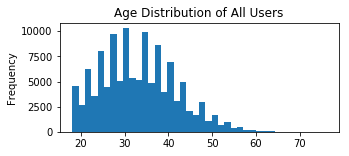

In [42]:
df_eda_t['age'].plot.hist(bins=40, title='Age Distribution of All Users', figsize=(5,2))
plt.show()

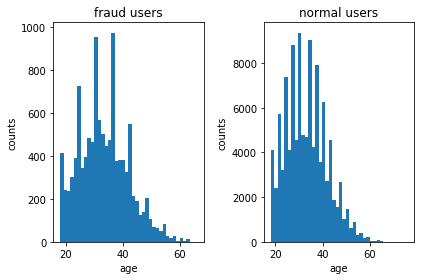

In [20]:
hist_fraud_vs_normal(df_eda_t, 'age', 40)

In [21]:
# bin users' age into 4 group
df_eda_t['age_binned'] = pd.qcut(df_eda_t['age'], 4)

In [24]:
# df_eda_t[['age_binned', 'fraud']].groupby(
#     ['age_binned']).mean()\
#     .plot.barh(figsize=(5,3), legend=False)
# plt.show()

**purchase_value**:  
* While `purchase_value` of normal users are normally distributed, fraud users have a significant count of small `purchase value`. 
* These transactions maybe used for fraud test. We could bin this feature, feed it into models, and see if it is a significant feature

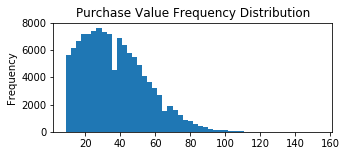

In [41]:
df_eda_t['purchase_value'].plot.hist(bins=50, 
                                   title='Purchase Value Frequency Distribution', 
                                   figsize=(5,2))
plt.show()

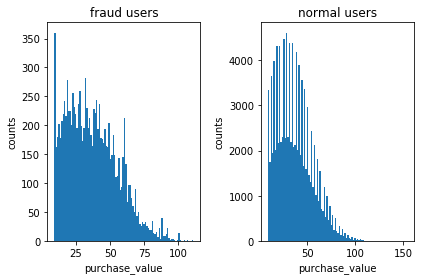

In [25]:
hist_fraud_vs_normal(df_eda_t, 'purchase_value', 100)

In [26]:
# discretize purchase_value
df_eda_t['purchase_value_binned'] = pd.qcut(df_eda_t['purchase_value'], q=[0., 0.02, 0.25, 0.5, 0.75, 1.])

* Fraudsters are tend to place multiple identical orders on same device when they find a loophole. We could generate a feature `order_cnt` to monitor how many orders with same value a customer place.

In [27]:
# duplicate orders
df_order = df_eda_t[['device_id', 'purchase_value', 'user_id']].groupby(
    ['device_id', 'purchase_value']).count().reset_index()[['device_id', 'user_id']].groupby(
    'device_id').max().rename(columns={'user_id':'order_cnt'})

In [28]:
# join new feature
df_eda_t = df_eda_t.set_index('device_id').join(df_order, how='left').reset_index()

In [29]:
# fill-in NA
df_eda_t['order_cnt'] = df_eda_t['order_cnt'].fillna(0)

**sex**: 
* Fraudsters are more likely to claim male as sex than female.

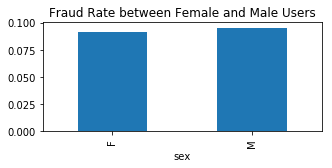

In [40]:
df_eda_t[['sex', 'fraud']].groupby(['sex']).mean().plot.bar(title='Fraud Rate between Female and Male Users', figsize=(5,2), legend=False)
plt.show()

**country**: 
* Users' geo distribution is skew and has a long tail.

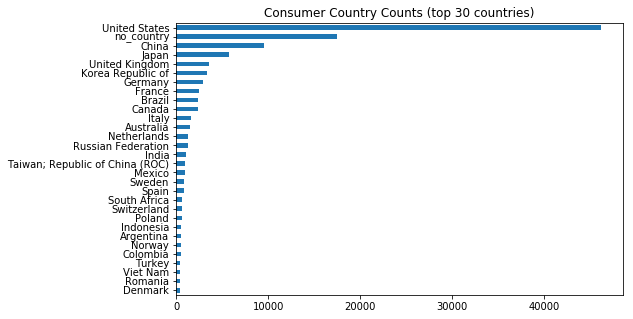

In [33]:
df_eda_t['country'].value_counts(ascending=True).tail(30).plot.barh(
    title = 'Consumer Country Counts (top 30 countries)', figsize=(8, 5), color='#1f77b4')
plt.show()

* Customers overseas are more likely to be fraudsters. 

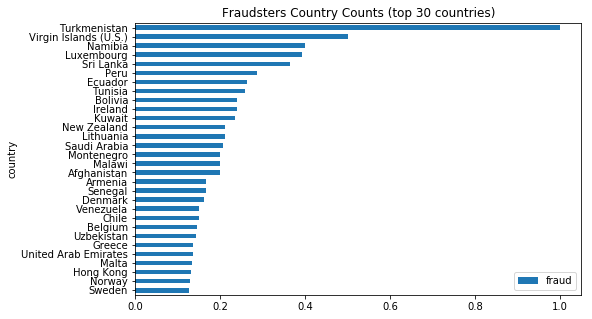

In [39]:
df_eda_t[['country', 'fraud']].groupby(['country']).mean().sort_values('fraud',ascending=True
      ).tail(30).plot.barh(title='Fraudsters Country Counts (top 30 countries)', figsize=(8,5))
plt.show()

* There are 177 countries. We could not keep all of them in the model for complexity control. We could simply split them into `freq_country` and `not_freq_country` based on fraud rate of each country.

In [35]:
print('Customers are from %d countries' % len(df_eda_t['country'].value_counts()))

Customers are from 177 countries


In [36]:
df_c = df_eda_t[['country', 'fraud']].groupby(['country']).mean().sort_values('fraud',ascending=True
      ).tail(30).reset_index()['country']
df_eda_t['country_freq'] = np.where((df_eda_t['country'].isin(df_c)), 'freq_country', 'not_freq_country')

### 2.2 Transaction Digital Foot Prints

**source**: 
* Most users come to visit via search engine result, and ads, while about 20% users come by directly typing web address.

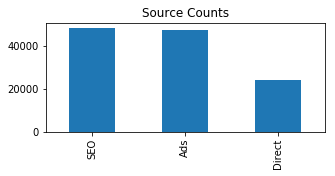

In [38]:
df_eda_t['source'].value_counts().plot.bar(title='Source Counts', figsize=(5,2),color='#1f77b4')
plt.show()

* Fraudsters are more likely to visit the site directly. 

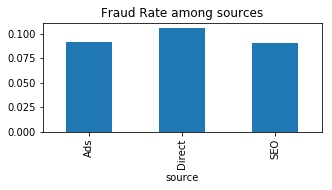

In [44]:
df_eda_t[['source', 'fraud']].groupby(['source']).mean().plot.bar(title='Fraud Rate among sources', 
                                                                  figsize=(5, 2), legend=False)
plt.show()

**browser**: 
* Chrome is the most popular browser among users.

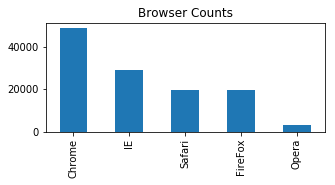

In [46]:
df_eda_t['browser'].value_counts().plot.bar(title='Browser Counts', figsize=(5,2),color='#1f77b4')
plt.show()

* Frausters are more likely to use Chrome as their browser. 

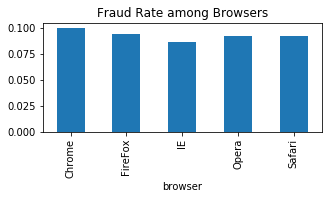

In [48]:
df_eda_t[['browser', 'fraud']].groupby(['browser']).mean().plot.bar(title='Fraud Rate among Browsers', figsize=(5,2), legend=False)
plt.show()

### 2.3 Times

* Absolute time may not be very useful. We could generate more time series features.

    * Some day of week, hour of day may be prefered by fraudsters. For example, if the fraud happends overseas, hour of day is very likely to be midnight of US. So we will create `day_of_week`, `hour_of_day` features respectively for `signup` and `purchase`.
    * Normal customers browse the website, compare products, and place orders. But fraudsters just want money, they may take short time browsing, and directly signup and purchase. So we will create a feature respresenting time length between signup and purchase, named `signup_purchase_delta`, and convert it to seconds. 

In [49]:
# generate day_of_week and hour_of_day for signup and purchase respectively.
df_eda_t['signup_day_of_week'] = df_eda_t['signup_time'].apply(lambda x: x.dayofweek)
df_eda_t['signup_hour_of_day'] = df_eda_t['signup_time'].apply(lambda x: x.hour)

df_eda_t['purchase_day_of_week'] = df_eda_t['purchase_time'].apply(lambda x: x.dayofweek)
df_eda_t['purchase_hour_of_day'] = df_eda_t['purchase_time'].apply(lambda x: x.hour)

In [50]:
# generate feature representing time difference between user's signup time and first purchase time.
df_eda_t['signup_purchase_delta'] = df_eda_t['purchase_time'] - df_eda_t['signup_time']

# transform unit of time difference to seconds
df_eda_t['signup_purchase_delta_seconds'] = df_eda_t['signup_purchase_delta'].apply(lambda x: x.total_seconds())

* Fraudsters are less active on Monday, Tuesday (GMT). 

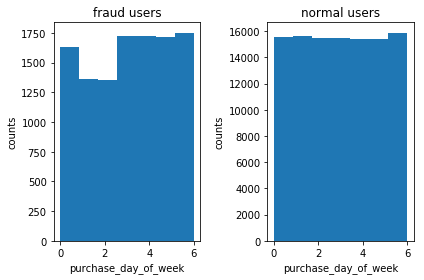

In [51]:
hist_fraud_vs_normal(df_eda_t, 'purchase_day_of_week', 7)

* Fraudsters' activity varies with regard to time, while normal users' activities distribute uniformly. 

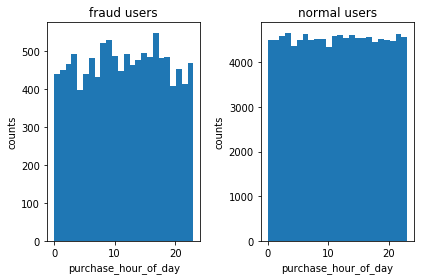

In [52]:
hist_fraud_vs_normal(df_eda_t, 'purchase_hour_of_day', 24)

* Besides, this feature has too many features which may make machine learning models too complex.

In [53]:
# bin purchase_hour_of_day to 4 groups
df_eda_t['purchase_hour_of_day_binned'] = pd.qcut(df_eda_t['purchase_hour_of_day'], 4)

In [55]:
# df_eda_t[['purchase_hour_of_day_binned', 'fraud']].groupby(
#     ['purchase_hour_of_day_binned']).mean()\
#     .plot.barh(figsize=(5,3), legend=False)
# plt.show()

* Most frausters finish purchasing soon after they signup, while normal users distribute uniformly. 

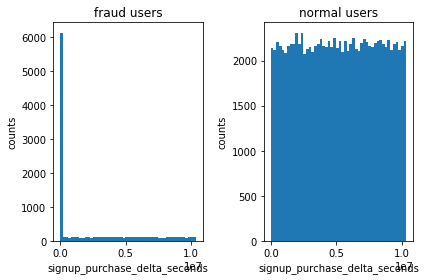

In [56]:
hist_fraud_vs_normal(df_eda_t, 'signup_purchase_delta_seconds', 50)

* Lots of fraud transactions happends right after user's signup, split the feature into `purchase_within_10s` and `purchase_after_10s`.

In [57]:
df_eda_t['signup_purchase_delta_seconds_binary'] = pd.cut(df_eda_t['signup_purchase_delta_seconds'], bins=[0, 10, float('inf')], 
                                                           labels=['purchase_within_10s', 'purchase_after_10s'])

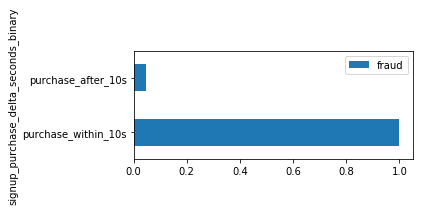

In [59]:
df_eda_t[['signup_purchase_delta_seconds_binary', 'fraud']].groupby(
    ['signup_purchase_delta_seconds_binary']).mean()\
    .plot.barh(figsize=(5,2))
plt.show()

### 2.4 Transaction Frequencies

* Fraudsters may use same `device_id` or same `ip_address` for multiple transactions.
* More than half of users who signed up with same device more than once are fraudulent. So we could generate features `signup_anomaly` and `ip_anomaly` to monitor users' signup and purchase behavior.

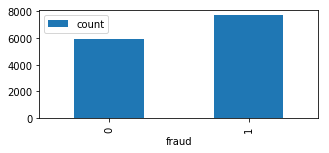

In [65]:
# get all devices signed up
devices = df_eda_t[['device_id', 'fraud']].set_index('device_id')
# devices that signed up duplicated
dup_device = df_eda_t['device_id'].value_counts().to_frame(name='count')
# compare number of fraudsters and normal users signed up on same device more than once
devices.join(dup_device[dup_device['count'] > 1], how='inner').groupby('fraud').count().plot.bar(figsize=(5,2))
plt.show()

In [61]:
# Find devices signup more than twice a day
df_eda_t['signup_date'] = df_eda_t['signup_time'].apply(lambda x: x.date()) # get date attribute
df_device = df_eda_t[['device_id', 'signup_date']].groupby('device_id').count()
df_device['signup_anomaly'] = np.where((df_device['signup_date'] <= 2), 0, 1)
df_device.drop('signup_date', axis=1, inplace=True) # remove temporary column

In [62]:
# join new feature signup_anomaly into dataframe
df_eda_t = df_eda_t.set_index('device_id').join(df_device, how='left').reset_index()

* Do the same job to `ip_address`, since fraudsters may use same ip to make multiple transaction.

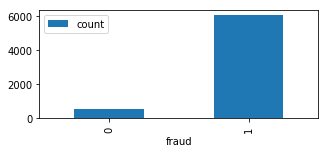

In [64]:
# get all ip_address used for signup
ip_addresses = df_eda_t[['ip_address', 'fraud']].set_index('ip_address')
# devices that signed up duplicated
dup_ip = df_eda_t['ip_address'].value_counts().to_frame(name='count')
# compare number of fraudsters and normal users signed up on same device more than once
ip_addresses.join(dup_ip[dup_ip['count'] > 1], how='inner').groupby('fraud').count().plot.bar(figsize=(5,2))
plt.show()

In [66]:
df_ip = df_eda_t['ip_address'].value_counts().to_frame(name='ip_count')

In [67]:
df_ip['ip_anomaly'] = np.where((df_ip['ip_count'] <= 2), 0, 1)
df_ip.drop('ip_count', axis=1, inplace=True)

In [68]:
# join new feature ip_anomaly into dataframe
df_eda_t = df_eda_t.set_index('ip_address').join(df_ip, how='left').reset_index()
# rename index -> ip_address
df_eda_t = df_eda_t.rename(columns={'index':'ip_address'})

* Generate transaction frequency features `{count}_signup_last_{time_window}_by_{device,ip}`
    * First, set the last time point of purchasing as the snapshot_time, and compute time difference between purchase and snapshot for every record.

In [69]:
df_eda_t['snapshot_time'] = max(df_eda_t['purchase_time'])
df_eda_t['snap_pur_time_delta'] = df_eda_t['snapshot_time'] - df_eda_t['purchase_time']
df_eda_t['snap_pur_time_delta'] = df_eda_t['snap_pur_time_delta'].apply(lambda x: float(x.total_seconds()))

In [70]:
# longest time window in the data
print('longest time window: ', max(df_eda_t['purchase_time']) - min(df_eda_t['signup_time']))
# so we split time window into most recent 1 day, 1 week, 2 weeks, 1 month, 3 months, 6 months, and 9 months
time_window_list = [86400, 604800, 1209600, 2592000, 7776000, 15552000, 23328000,31104000]

longest time window:  349 days 02:55:22


In [71]:
for time_window in time_window_list:
    df_eda_t['last_'+str(time_window//86400)+'_day'] = np.where(
        (df_eda_t['snap_pur_time_delta'] < time_window), 1, 0)

In [72]:
recency_list = []
for time_window in time_window_list:
    recency_list.append('last_'+str(time_window//86400)+'_day')

In [73]:
# make a copy of df_eda_t, since df_eda_t will be assigned an index later.
df_eda_tt = df_eda_t.copy() 
df_eda_t = df_eda_t.set_index('device_id')

In [74]:
for recency in recency_list:
    tt = df_eda_tt[[recency, 'device_id', 'user_id']][
        df_eda_tt[recency]==1].groupby(
        'device_id').count().drop(recency, axis=1).rename(
        columns={'user_id':'count_signup_'+str(recency)+'_by_device'})
    tt = tt['count_signup_'+str(recency)+'_by_device'].fillna(0)
    df_eda_t = df_eda_t.join(tt, how='left')

In [75]:
# fill-in na 
for recency in recency_list:
    df_eda_t['count_signup_'+str(recency)+'_by_device'] = df_eda_t['count_signup_'+str(recency)+'_by_device'].fillna(0)

In [76]:
df_eda_t = df_eda_t.reset_index()

* Do the same to ip_address. 

In [77]:
df_eda_t = df_eda_t.set_index('ip_address')

In [78]:
for recency in recency_list:
    tt = df_eda_tt[[recency, 'ip_address', 'user_id']][
        df_eda_tt[recency]==1].groupby(
        'ip_address').count().drop(recency, axis=1).rename(
        columns={'user_id':'count_signup_'+str(recency)+'_by_ip'})
    tt = tt['count_signup_'+str(recency)+'_by_ip'].fillna(0)
    df_eda_t = df_eda_t.join(tt, how='left')

In [79]:
# fill-in na 
for recency in recency_list:
    df_eda_t['count_signup_'+str(recency)+'_by_ip'] = df_eda_t['count_signup_'+str(recency)+'_by_ip'].fillna(0)

In [80]:
df_eda_t = df_eda_t.reset_index()

## <a id='build' style='color:black'>3. Model Building</a>
[back to summary](#summary)

### 3.1 Metrics for Mondel Comparision

* precision, recall, f1-score
* ROC plot and AUC
* Profit curve

**precision, recall, f1-score:** We can get accuracy, precision, recall, and f1-score through `sklearn`. Here, since our data is highly imbalanced, we should consider both precision and racall, rather than just accuracy.

In [81]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

In [82]:
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5): 
    # threshold = 0.5, better than random guess.
    metric_names = ['AUC', 'Accuracy', 'Precision', 'Recall', 'f1-score']
    metric_values_train = [
        roc_auc_score(y_train, y_train_pred), 
        accuracy_score(y_train, y_train_pred>threshold),
        precision_score(y_train, y_train_pred>threshold), 
        recall_score(y_train, y_train_pred>threshold), 
        f1_score(y_train, y_train_pred>threshold)
    ]
    
    metric_values_test = [
        roc_auc_score(y_test, y_test_pred), 
        accuracy_score(y_test, y_test_pred>threshold),
        precision_score(y_test, y_test_pred>threshold), 
        recall_score(y_test, y_test_pred>threshold), 
        f1_score(y_test, y_test_pred>threshold)
    ]
    
    all_metrics = pd.DataFrame({
        'metrics': metric_names,
        'train': metric_values_train,
        'test': metric_values_test,
    }, columns = ['metrics', 'train', 'test']).set_index('metrics')
    
    print(all_metrics)

**ROC plot**

In [83]:
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green', 
            lw=lw, label="ROC Train (AUC = %0.4f)" % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange', 
            lw=lw, label="ROC Test (AUC = %0.4f)" % roc_auc_test)
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()

**Profit curve:** The cost benefit matrix defined here is in dollars. We will lose the money if we fail to identify a fraudulent transaction. We will cost value $8 if we incorrectly flag a transaction as fraudulent. 

matrix      | Actual + | Actual -
------------|----------|----------
Predicted + | TP  | FP ($8)
Predicted - | FN (purchase_value) | TN 

I don't have time to write code plotting profit curve. I will leave this as next step. 
Profit curve is a very good measure for model selection when given cost and benifit of business. 

### 3.2 Model Building Preparation
* Define a function integrated with common statements for training model with sklearn

In [86]:
# define function to perform train, test, and get model performance
def train_test_model(clf, X_train, y_train, X_test, y_test):
    # fit model with training data
    clf.fit(X_train, y_train)
    
    # make prediction on training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:, 1]
    
    # make prediction on testing data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:, 1]
    
    # model performance
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

### 3.3 Logistic Regression

In [87]:
df_model_lr = df_eda_t.copy()

#### 3.3.1 Trainin Data preparation
**Select features**

In [88]:
col_cat = ['source', 'browser', 'age_binned', 'purchase_value_binned',
           'signup_day_of_week', 
           'purchase_day_of_week', 
           'purchase_hour_of_day_binned', 
          'signup_purchase_delta_seconds_binary',
          'country_freq']
col_other = ['fraud', 'signup_anomaly', 'ip_anomaly', 
             'count_signup_last_90_day_by_device',
             'count_signup_last_180_day_by_device',
             'count_signup_last_270_day_by_device',
             'count_signup_last_360_day_by_device',
             'count_signup_last_90_day_by_ip',
             'count_signup_last_180_day_by_ip',
             'count_signup_last_270_day_by_ip',
             'count_signup_last_360_day_by_ip',
             'order_cnt'
            ]

**One-hot encoding**

In [89]:
df_dummies = pd.get_dummies(df_model_lr[col_cat], columns=col_cat)
df_model_lr = df_model_lr[col_other].join(df_dummies)

**Define features and target**

In [90]:
selected_features = list(df_model_lr.columns.values)
selected_features.remove('fraud')
X = df_model_lr[selected_features]
y = df_model_lr['fraud']
X.shape, y.shape

((120000, 50), (120000,))

**Feature standardization**

In [91]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
SX=scaler.fit_transform(X, y)

**Train test data split**

In [92]:
from sklearn.model_selection import train_test_split
SX_train, SX_test, y_train, y_test = train_test_split(SX, y, test_size=0.3, random_state=42)

#### 3.3.2 Model Training

              train      test
metrics                      
AUC        0.839550  0.826006
Accuracy   0.955952  0.957028
Precision  0.999768  0.998831
Recall     0.538260  0.525200
f1-score   0.699773  0.688419


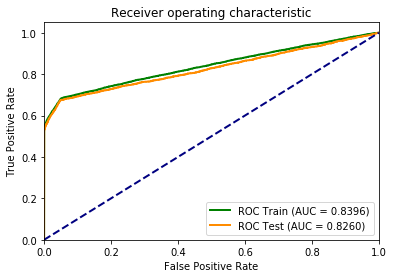

In [93]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1.0, penalty='l2') # initialize model
clf.fit(SX_train, y_train) # fit a model by providing X and y from training set

train_test_model(clf, SX_train, y_train, SX_test, y_test) # make prediction on train and test data

* Model Performance
    * `logistic regression` automacally avoid overfitting by add penalization. 
    * `logistic regression` is good for interpretation. See coefficients understanding below.

* Understanding the Estimated Coefficients
    * Customers, who place order after browsing the webpage more than 10s, are very likely to be normal, while conversely, frausters place order immediately after signing up.
    * Customers come to purchase by directly typing web address are more likely to be fraudsters, while those customers come thru ads or search engine results are more likely to be normal.
    * Customers signed up multiple times on same device are more likely to be fraudsters. 
    * It seems like fraudsters take care of their ip address, customers signup multiple times at same ip address are more likely to be normal.

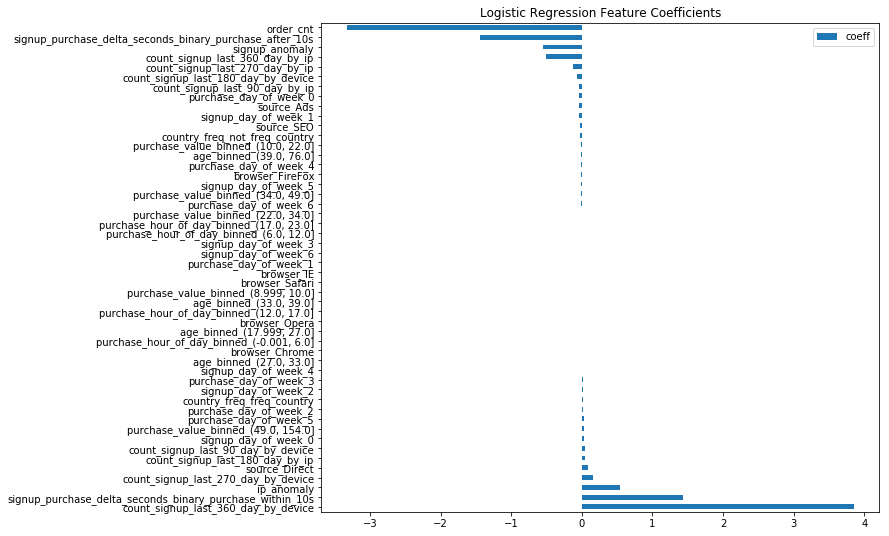

In [97]:
# plot eastimated coefficients of logistic regression
df_coeffs = pd.DataFrame(list(zip(selected_features, clf.coef_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'coeff']

ax = df_coeffs.plot.barh(title='Logistic Regression Feature Coefficients', figsize=(10,9))
t = np.arange(X.shape[1])
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
plt.show()

### 3.4 Random forest

In [98]:
df_model = df_eda_t.copy()

**Select features**

In [99]:
col_cat = ['source', 'browser', 'signup_day_of_week', 'purchase_day_of_week', 
           'purchase_hour_of_day', 'country_freq']
col_other = ['fraud', 'purchase_value', 'signup_anomaly', 'ip_anomaly', 'age',
             'signup_purchase_delta_seconds',
            'count_signup_last_1_day_by_device','count_signup_last_7_day_by_device',
             'count_signup_last_14_day_by_device','count_signup_last_30_day_by_device',
             'count_signup_last_90_day_by_device','count_signup_last_180_day_by_device',
             'count_signup_last_270_day_by_device','count_signup_last_360_day_by_device',
             'count_signup_last_1_day_by_ip','count_signup_last_7_day_by_ip',
             'count_signup_last_14_day_by_ip','count_signup_last_30_day_by_ip',
             'count_signup_last_90_day_by_ip','count_signup_last_180_day_by_ip',
             'count_signup_last_270_day_by_ip','count_signup_last_360_day_by_ip',
             'order_cnt']

In [100]:
df_dummies = pd.get_dummies(df_model[col_cat], columns=col_cat)

In [101]:
df_model = df_model[col_other].join(df_dummies)

**Define features and target**

In [106]:
selected_features = list(df_model.columns.values)
selected_features.remove('fraud')
X = df_model[selected_features]
y = df_model['fraud']
X.shape, y.shape

((120000, 70), (120000,))

**Train test data split**

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

              train      test
metrics                      
AUC        0.979360  0.828326
Accuracy   0.955964  0.957028
Precision  1.000000  0.998831
Recall     0.538260  0.525200
f1-score   0.699830  0.688419


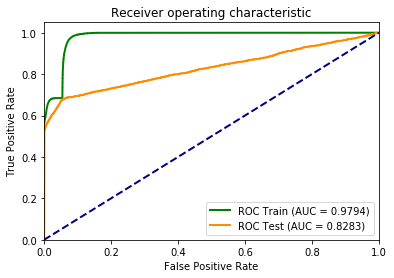

In [108]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators':400,
    'max_features':'auto',
    'criterion':'gini',
    'max_depth':25,
    'min_samples_split':2,
    'min_samples_leaf':10,
    'random_state':0,
    'n_jobs':-1
}

clf = RandomForestClassifier(**parameters)
clf.fit(X_train, y_train)
train_test_model(clf, X_train, y_train, X_test, y_test)

**Random Forest Feature Importance**

Significant features of random forest are similar to those in logistic regression model.

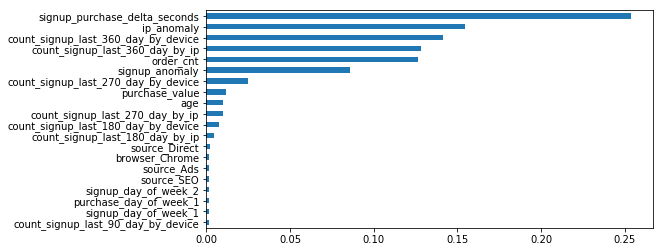

In [112]:
df_feature_importance = pd.DataFrame()
df_feature_importance['feature'] = selected_features
df_feature_importance['importance'] = clf.feature_importances_
df_feature_importance.sort_values('importance', inplace=True)

ax = df_feature_importance.sort_values('importance', ascending=True).tail(20).plot.barh(figsize=(8, 4),legend=False)
t = np.arange(20)
ax.set_yticks(t)
ax.set_yticklabels(df_feature_importance.sort_values('importance', ascending=True).tail(20)['feature'])

plt.show()

* Just little improvement compared with `logistic regression`. 
* The model is overfitting.
* Need more tuning. 

### 3.5 Gradient Boosting Trees

              train      test
metrics                      
AUC        0.867153  0.829341
Accuracy   0.956452  0.956917
Precision  0.999312  0.994196
Recall     0.543752  0.526429
f1-score   0.704285  0.688366


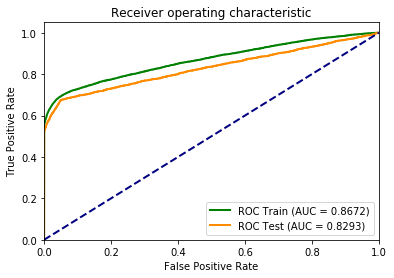

In [113]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = { # Choose some parameter combinations to try
    'n_estimators':200,
    'max_depth':3,
    'learning_rate':0.1,
    'subsample':0.7,
    'max_features':0.8,
    'random_state': 42 
}

clf = GradientBoostingClassifier(**parameters) # initialize classifier

train_test_model(clf, X_train, y_train, X_test, y_test) # Train test model

**Without any model tuning, gradient boosting seems to have the best performance** based on the metrics: highest recall, ROC plot with highest AUC. And it doesn't overfitting like random forest tree.

All the 3 models' performance are poor on recall. Comparing fraud users amount and normal user amount, we could see this is because the data set is imbalanced. 

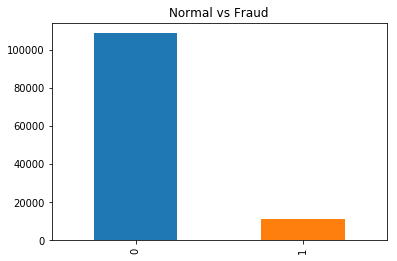

In [114]:
df_eda_t['fraud'].value_counts().plot.bar(title='Normal vs Fraud')
plt.show()

###  3.6 Sampling

* The dataset is highly imbalance. Models built on imbalanced data tend to show a bias to the majority class, treating the minority class as noise. 
* Moreover, model evaluation metrics have problems, too. When accuracy seems very high, it may just ignore the minority class. So the classifiers are unreliable.
* Methods dealing with imbalanced data including, down-sampling, and over-sampling. 

Here, we will use `down-sampling`. 
* Downsample majority class to match minority class

In [115]:
# df_down_sample = df_eda_t.copy()
df_down_sample = df_model.copy()

In [116]:
i_class_fraud = df_down_sample[df_down_sample['fraud'] == 1].index.values
i_class_normal = df_down_sample[df_down_sample['fraud'] == 0].index.values

In [117]:
n_class_fraud = len(i_class_fraud)
n_class_normal = len(i_class_normal)

In [118]:
i_class_normal_downsampled = np.random.choice(i_class_normal, size = n_class_fraud, replace=False)

In [119]:
df_down_sample = pd.concat([df_down_sample.iloc[i_class_normal_downsampled], 
           df_down_sample.iloc[i_class_fraud]])

In [120]:
df_down_sample_model = df_down_sample.copy()

* Apply random forest on down-sampled dataset.

In [121]:
# define features and target
selected_features = list(df_down_sample_model.columns.values)
selected_features.remove('fraud')
X = df_down_sample_model[selected_features]
y = df_down_sample_model['fraud']
X.shape, y.shape

((22530, 70), (22530,))

In [122]:
# train, test data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

              train      test
metrics                      
AUC        0.958989  0.834936
Accuracy   0.812758  0.817872
Precision  0.925424  0.931189
Recall     0.681910  0.682890
f1-score   0.785221  0.787941


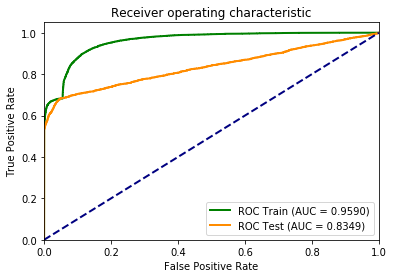

In [123]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators':400,
    'max_features':'auto',
    'criterion':'gini',
    'max_depth':25,
    'min_samples_split':2,
    'min_samples_leaf':10,
    'random_state':0,
    'n_jobs':-1
}

clf = RandomForestClassifier(**parameters)
clf.fit(X_train, y_train)
train_test_model(clf, X_train, y_train, X_test, y_test)

* Apply gradient boosting tree on down-sampled dataset. 

              train      test
metrics                      
AUC        0.891114  0.831127
Accuracy   0.817703  0.817725
Precision  0.934045  0.933279
Recall     0.685195  0.680800
f1-score   0.790498  0.787293


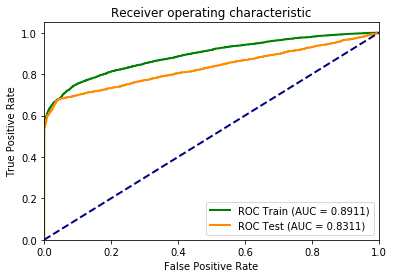

In [124]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    'n_estimators':200,
    'max_depth':3,
    'learning_rate':0.1,
    'subsample':0.7,
    'max_features':0.8,
    'random_state': 42
}

clf = GradientBoostingClassifier(**parameters)

# Train test model
train_test_model(clf, X_train, y_train, X_test, y_test)

Recall of random forest and gradient boosting trees are both boosted. 

## <a id='tune' style='color:black'>4. Hyperparameter Tuning</a>
[back to summary](#summary)

* Tuning models by `GridSearch` to automatically search best parameters. `GridSearch` uses cross validation inherently. 

**Tuning random forest parameters**

In [125]:
# tune model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
# Choose the type of classifier. 
clf_rf = RandomForestClassifier()
# Choose some parameter combinations to try
param_grid = {'n_estimators': [100, 150, 200], 
              'max_features': ['auto'], 
              'criterion': ['gini'],
              'max_depth': [20,25], 
              'min_samples_split': [2],
              'min_samples_leaf': [2,5,10],
              'n_jobs':[-1]
             }
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(roc_auc_score)
# Run the grid search
grid_obj = GridSearchCV(clf_rf, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
# Set the clf to the best combination of parameters
clf_rf = grid_obj.best_estimator_
# Fit the best algorithm to the data. 
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              train      test
metrics                      
AUC        0.982954  0.835886
Accuracy   0.830258  0.818464
Precision  0.960774  0.933061
Recall     0.689995  0.682592
f1-score   0.803176  0.788412


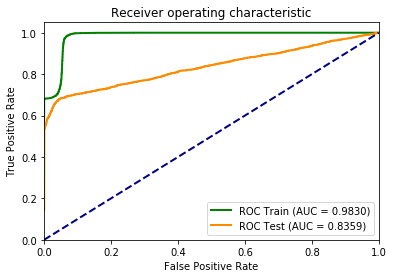

In [126]:
# Rebuild random forest classifiers with best parameters from grid search
train_test_model(clf_rf, X_train, y_train, X_test, y_test)

**Tuning gradient boosting tree parameters**

In [127]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

clf_gb = GradientBoostingClassifier()

param_grid = {
    # tree_size
    'max_depth':[3,5],
#     'max_leaf_nodes':[4,6],
    # regulating overfitting
    'n_estimators': [100,200],
    'learning_rate':[0.1, 0.05],
    'random_state': [42]
}
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(roc_auc_score)
# Run the grid search
grid_obj = GridSearchCV(clf_gb, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
# Set the clf to the best combination of parameters
clf_gb = grid_obj.best_estimator_
# Fit the best algorithm to the data. 
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

              train      test
metrics                      
AUC        0.869213  0.835317
Accuracy   0.816308  0.818760
Precision  0.933046  0.937397
Recall     0.683047  0.679606
f1-score   0.788710  0.787952


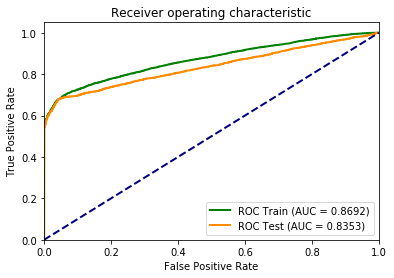

In [128]:
# Rebuild gradient boost classifiers with best parameters from grid search
train_test_model(clf_gb, X_train, y_train, X_test, y_test)

In [359]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV

clf_gb = GradientBoostingClassifier()

param_grid = {
    # tree_size
    'max_depth':[3,5],
#     'max_leaf_nodes':[4,6],
    # regulating overfitting
    'n_estimators': [100,200],
    'learning_rate':[0.1, 0.05],
    'random_state': [42]
}
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(roc_auc_score)
# Run the grid search
grid_obj = GridSearchCV(clf_gb, param_grid, cv=5, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
# Set the clf to the best combination of parameters
clf_gb = grid_obj.best_estimator_
# Fit the best algorithm to the data. 
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

              train      test
metrics                      
AUC        0.854533  0.836288
Accuracy   0.814533  0.819648
Precision  0.930927  0.938633
Recall     0.681026  0.680502
f1-score   0.786605  0.788991


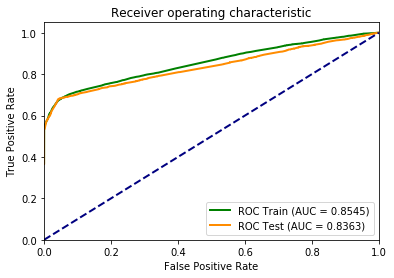

In [360]:
# Rebuild gradient boost classifiers with best parameters from grid search
train_test_model(clf_gb, X_train, y_train, X_test, y_test)

### Final model
Gradient boosting tree has a better performance.

In [131]:
from sklearn.externals import joblib

In [132]:
# save the model to disk
filename = '../finalized_model/fraud_classifier.sav'
joblib.dump(clf_rf, filename)

['../finalized_model/fraud_classifier.sav']

In [133]:
from sklearn.externals import joblib

# load model
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result) # accuracy

0.8184642698624057


In [137]:
# Probability of first transaction of a new user is fraudulent.
p_test_pred = loaded_model.predict_proba(X_test)[:, 1] 
print(p_test_pred)

[0.72672511 0.32461139 0.24810769 ... 0.67299079 0.27876293 0.67922511]


## <a id='findings' style='color:black'>5. Findings & Suggestion</a>
[back to summary](#summary)

**5.1 Findings - Fraud chracteristics**
* Fraudsters signup on same device for multiple times.
* Fraudsters take care about their ip address. (They may use VPN.) Signing up multiple times at same ip address may be just happened to normal users.
* Fraudsters make purchase immediately after signing up.
* Fraudsters place many orders with identical purchase value.
* Fraudsters more likely to visit the website directly, instead of searching or converting by ads.
* Fraudsters are more likely to use Chrome than other browsers.

**5.2 Suggestions**
* Limit products' purchasing amount per day. 
* Ask customer fillin CAPTCHA when he/she purchase for the first time. 
* Limit signup times on each device, in case frausters signup multiple times in a short time.
* Increase chance of showing CAPTCHA for user validation, if the user comes to visit the website directly, or visits by Chrome. 

## <a id='eval' style='color:black'>6. Model Evaluation on Test Data</a>
[back to summary](#summary)

In [ ]:
import pandas as pd
import numpy as np
from pandasql import sqldf

df_fraud = pd.read_csv('path/to/test_data') # test_data
df_ip = pd.read_csv('../data/IpAddress_to_Country.csv')

In [ ]:
# join dataframes, to determine users' countries. 
pysqldf = lambda q: sqldf(q, globals())

q = """
SELECT *
FROM df_fraud f
LEFT JOIN df_ip i
WHERE f.ip_address >= i.lower_bound_ip_address
AND f.ip_address <= i.upper_bound_ip_address
"""

joined = pysqldf(q)

In [ ]:
# Feature transformation, same as processings to training data.
# drop unnecessary column 'lower_bound_ip_address' and 'upper_bound_ip_address'
joined_selected = joined.drop(['lower_bound_ip_address', 'upper_bound_ip_address'], axis=1)
# get user_ids with country identified
mask = joined_selected['user_id']
# get records with country unidentified
df_country_unidentified = df_fraud[~df_fraud['user_id'].isin(mask)]
# name unidentified records' country as no_country
df_country_unidentified['country'] = 'no_country'

# concat all records
frames = [joined_selected, df_country_unidentified]
df_fraud_with_country = pd.concat(frames)

df_fraud_with_country.drop('Unnamed: 0', axis=1, inplace=True)

# transform time-series variable
df_fraud_with_country['signup_time'] = pd.to_datetime(df_fraud_with_country['signup_time'])
df_fraud_with_country['purchase_time'] = pd.to_datetime(df_fraud_with_country['purchase_time'])

# rename target variable
df_fraud_with_country = df_fraud_with_country.rename(columns={'class': 'fraud'})


df_eda_t = df_fraud_with_country.copy()

df_eda_t['age_binned'] = pd.qcut(df_eda_t['age'], 4)
df_eda_t['purchase_value_binned'] = pd.qcut(df_eda_t['purchase_value'], q=[0., 0.02, 0.25, 0.5, 0.75, 1.])

# duplicate orders
df_order = df_eda_t[['device_id', 'purchase_value', 'user_id']].groupby(
    ['device_id', 'purchase_value']).count().reset_index()[['device_id', 'user_id']].groupby(
    'device_id').max().rename(columns={'user_id':'order_cnt'})

df_eda_t = df_eda_t.set_index('device_id').join(df_order, how='left').reset_index()

df_eda_t['order_cnt'] = df_eda_t['order_cnt'].fillna(0)

df_c = df_eda_t[['country', 'fraud']].groupby(['country']).mean().sort_values('fraud',ascending=True
      ).tail(30).reset_index()['country']

df_eda_t['country_freq'] = np.where((df_eda_t['country'].isin(df_c)), 'freq_country', 'not_freq_country')

# generate day_of_week and hour_of_day for signup and purchase respectively.
df_eda_t['signup_day_of_week'] = df_eda_t['signup_time'].apply(lambda x: x.dayofweek)
df_eda_t['signup_hour_of_day'] = df_eda_t['signup_time'].apply(lambda x: x.hour)

df_eda_t['purchase_day_of_week'] = df_eda_t['purchase_time'].apply(lambda x: x.dayofweek)
df_eda_t['purchase_hour_of_day'] = df_eda_t['purchase_time'].apply(lambda x: x.hour)

# generate feature representing time difference between user's signup time and first purchase time.
df_eda_t['signup_purchase_delta'] = df_eda_t['purchase_time'] - df_eda_t['signup_time']

# transform unit of time difference to seconds
df_eda_t['signup_purchase_delta_seconds'] = df_eda_t['signup_purchase_delta'].apply(lambda x: x.total_seconds())

# bin purchase_hour_of_day to 4 groups
df_eda_t['purchase_hour_of_day_binned'] = pd.qcut(df_eda_t['purchase_hour_of_day'], 4)

df_eda_t['signup_purchase_delta_seconds_binary'] = pd.cut(df_eda_t['signup_purchase_delta_seconds'], bins=[0, 10, float('inf')], 
                                                           labels=['purchase_within_10s', 'purchase_after_10s'])

# Find devices signup more than twice a day
df_eda_t['signup_date'] = df_eda_t['signup_time'].apply(lambda x: x.date()) # get date attribute
df_device = df_eda_t[['device_id', 'signup_date']].groupby('device_id').count()
df_device['signup_anomaly'] = np.where((df_device['signup_date'] <= 2), 0, 1)
df_device.drop('signup_date', axis=1, inplace=True) # remove temporary column

# join new feature signup_anomaly into dataframe
df_eda_t = df_eda_t.set_index('device_id').join(df_device, how='left').reset_index()


df_ip = df_eda_t['ip_address'].value_counts().to_frame(name='ip_count')

df_ip['ip_anomaly'] = np.where((df_ip['ip_count'] <= 2), 0, 1)
df_ip.drop('ip_count', axis=1, inplace=True)

# join new feature ip_anomaly into dataframe
df_eda_t = df_eda_t.set_index('ip_address').join(df_ip, how='left').reset_index()
# rename index -> ip_address
df_eda_t = df_eda_t.rename(columns={'index':'ip_address'})

df_eda_t['snapshot_time'] = max(df_eda_t['purchase_time'])
df_eda_t['snap_pur_time_delta'] = df_eda_t['snapshot_time'] - df_eda_t['purchase_time']
df_eda_t['snap_pur_time_delta'] = df_eda_t['snap_pur_time_delta'].apply(lambda x: float(x.total_seconds()))

time_window_list = [86400, 604800, 1209600, 2592000, 7776000, 15552000, 23328000,31104000]

for time_window in time_window_list:
    df_eda_t['last_'+str(time_window//86400)+'_day'] = np.where(
        (df_eda_t['snap_pur_time_delta'] < time_window), 1, 0)

recency_list = []
for time_window in time_window_list:
    recency_list.append('last_'+str(time_window//86400)+'_day')
    
# make a copy of df_eda_t, since df_eda_t will be assigned an index later.
df_eda_tt = df_eda_t.copy() 
df_eda_t = df_eda_t.set_index('device_id')

for recency in recency_list:
    tt = df_eda_tt[[recency, 'device_id', 'user_id']][
        df_eda_tt[recency]==1].groupby(
        'device_id').count().drop(recency, axis=1).rename(
        columns={'user_id':'count_signup_'+str(recency)+'_by_device'})
    tt = tt['count_signup_'+str(recency)+'_by_device'].fillna(0)
    df_eda_t = df_eda_t.join(tt, how='left')
    
# fill-in na 
for recency in recency_list:
    df_eda_t['count_signup_'+str(recency)+'_by_device'] = df_eda_t['count_signup_'+str(recency)+'_by_device'].fillna(0)
    
df_eda_t = df_eda_t.reset_index()

df_eda_t = df_eda_t.set_index('ip_address')

for recency in recency_list:
    tt = df_eda_tt[[recency, 'ip_address', 'user_id']][
        df_eda_tt[recency]==1].groupby(
        'ip_address').count().drop(recency, axis=1).rename(
        columns={'user_id':'count_signup_'+str(recency)+'_by_ip'})
    tt = tt['count_signup_'+str(recency)+'_by_ip'].fillna(0)
    df_eda_t = df_eda_t.join(tt, how='left')
    
# fill-in na 
for recency in recency_list:
    df_eda_t['count_signup_'+str(recency)+'_by_ip'] = df_eda_t['count_signup_'+str(recency)+'_by_ip'].fillna(0)
    
df_eda_t = df_eda_t.reset_index()

In [ ]:
df_model = df_eda_t.copy()

col_cat = ['source', 'browser', 'signup_day_of_week', 'purchase_day_of_week', 
#            'age_binned',
           'purchase_hour_of_day', 'country_freq'
          ]

col_other = ['fraud', 'purchase_value', 'signup_anomaly', 'ip_anomaly', 
             'age',
             'signup_purchase_delta_seconds',
            'count_signup_last_1_day_by_device',
             'count_signup_last_7_day_by_device',
             'count_signup_last_14_day_by_device',
             'count_signup_last_30_day_by_device',
             'count_signup_last_90_day_by_device',
             'count_signup_last_180_day_by_device',
             'count_signup_last_270_day_by_device',
             'count_signup_last_360_day_by_device',
             'count_signup_last_1_day_by_ip',
             'count_signup_last_7_day_by_ip',
             'count_signup_last_14_day_by_ip',
             'count_signup_last_30_day_by_ip',
             'count_signup_last_90_day_by_ip',
             'count_signup_last_180_day_by_ip',
             'count_signup_last_270_day_by_ip',
             'count_signup_last_360_day_by_ip',
             'order_cnt'
            ]

df_dummies = pd.get_dummies(df_model[col_cat], columns=col_cat)

df_model = df_model[col_other].join(df_dummies)

selected_features = list(df_model.columns.values)

selected_features.remove('fraud')

X_test = df_model[selected_features]
y_test = df_model['fraud']

In [ ]:
from sklearn.externals import joblib

# load model
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result) # accuracy

In [ ]:
# Probability of first transaction of a new user is fraudulent.
p_test_pred = loaded_model.predict_proba(X_test)[:, 1] 
print(p_test_pred)